[Previous: Time series features](04-Time-series-features.ipynb)
• [Contents](Contents.ipynb)
• [Next: Judgemental forecasts](06-Judgmental-forecasts.ipynb)

# 5 The forecaster’s toolbox

[FPP3 Chapter 5](https://otexts.com/fpp3/toolbox.html)

* [5.1 A tidy forecasting workflow](#5.1-A-tidy-forecasting-workflow)
* [5.2 Some simple forecasting methods](#5.2-Some-simple-forecasting-methods)
* [5.3 Fitted values and residuals](#5.3-Fitted-values-and-residuals)
* [5.4 Residual diagnostics](#5.4-Residual-diagnostics)
* [5.5 Distributional forecasts and prediction intervals](#5.5-Distributional-forecasts-and-prediction-intervals)
* [5.6 Forecasting using transformations](#5.6-Forecasting-using-transformations)
* [5.7 Forecasting with decomposition](#5.7-Forecasting-with-decomposition)
* [5.8 Evaluating forecast accuracy](#5.8-Evaluating-forecast-accuracy)
* [5.9 Time series cross-validation](#5.9-Time-series-cross-validation)

<hr/>

In [1]:
import sys
sys.path.insert(0, '.')
from utils import *

[utils.py](utils.py)

## 5.1 A tidy forecasting workflow

[FPP3 Section 5.1](https://otexts.com/fpp3/a-tidy-forecasting-workflow.html)

### Data preparation (tidy)

### Plot the data (visualise)

In [2]:
global_economy = (
    pd.read_csv('data/global_economy.csv')
    .pipe(compute, lambda x: dict(
        date = pd.to_datetime(x.Year, format='%Y'),
        GDP = x.GDP / 1e12))
    .set_index('date')
)

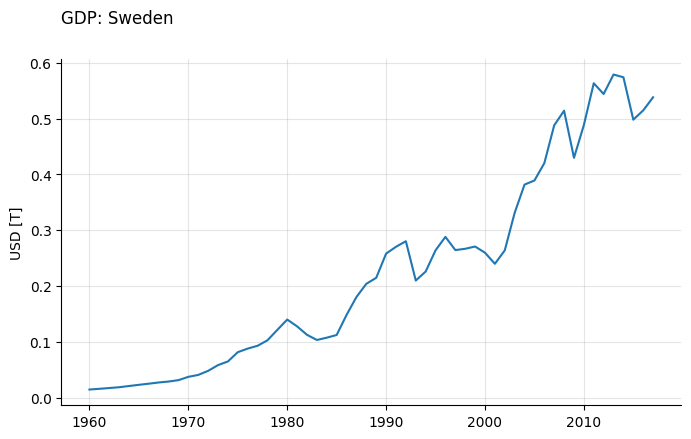

In [3]:
d = sweden_economy = global_economy.query("Country == 'Sweden'").copy()
fig, ax = plt.subplots()
ax.plot(d.GDP)
ax.set(ylabel='USD [T]')
suptitle('GDP: Sweden')
plt.grid()

### Define a model (specify)

As far as I can tell, this cute syntax is not available for most of the really useful models in statsmodels, so we're gonna take advantage while we can.

In [4]:
smf.ols('GDP ~ Year', sweden_economy)

### Train the model (estimate)

In [5]:
models = (
    global_economy
    [~global_economy.GDP.isna()]
    .groupby('Country')
    .pipe(summarize, lambda x: dict(
        trend_model = smf.ols('GDP ~ Year', x).fit()
    ))
)

### Check model performance (evaluate)

See Section 5.8; this is just a random plot.

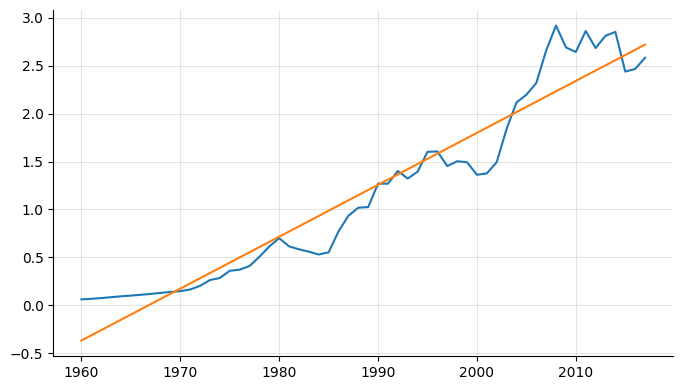

In [6]:
fig, ax = plt.subplots()
country = 'France'
economy = global_economy[global_economy.Country.eq(country)]
ax.plot(economy.GDP)
m = models.trend_model[country]
pred = m.get_prediction(economy).summary_frame()
ax.plot(economy.index, pred['mean'])
ax.grid()

### Produce forecasts (forecast)

In [7]:
global_economy.Year.max()

2017

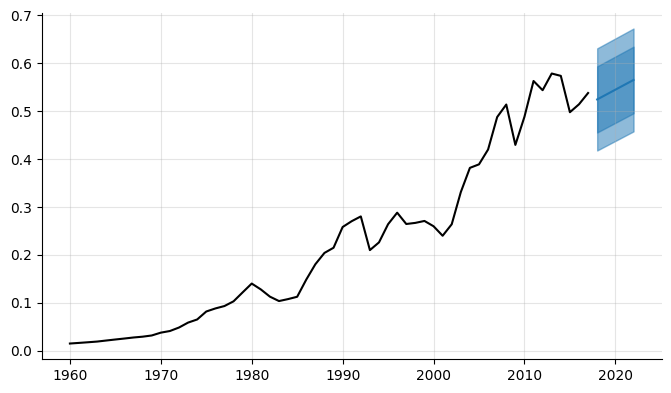

In [8]:
fig, ax = plt.subplots()
country = 'Sweden'
economy = global_economy[global_economy.Country.eq(country)]
ax.plot(economy.Year, economy.GDP, color='k')
m = models.trend_model[country]
x = pd.Series(dict(Year=np.arange(2018, 2023)))
pred95 = m.get_prediction(x).summary_frame()
pred80 = m.get_prediction(x).summary_frame(alpha=.2)
ax.plot(x.Year, pred80['mean'])
ax.fill_between(x.Year, pred95.obs_ci_lower, pred95.obs_ci_upper, color='C0', alpha=.5)
ax.fill_between(x.Year, pred80.obs_ci_lower, pred80.obs_ci_upper, color='C0', alpha=.5)
plt.grid()

## 5.2 Some simple forecasting methods

[FPP3 Section 5.2](https://otexts.com/fpp3/simple-methods.html)

### SimpleTS

Here we get into some really simple baseline models: naive, mean, seasonal naive, drift.  Most, if not all, of these can be done by using [SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) in a very specific way.  However, for learning's sake (and because I couldn't figure out how to use SARIMAX for these simple cases without learning much more about what it does) we're going to use the following interface.

In [9]:
class SimpleTSModel:
    """Simple TS model base class."""
    def __init__(self, y):
        """Determine y data and sampling frequency."""
        if not hasattr(y, 'index'):
            y = pd.Series(y)
        if hasattr(y.index, 'inferred_freq'):
            self.y = y.asfreq(y.index.inferred_freq)
            self.freq = self.y.index.freq
        else:
            self.y = y.copy()
            self.freq = None
        
    def fit(self):
        """Nothing to do here, but in other libraries this is a method that does things."""
        return self

    def forecast(self, dt=None, end=None, periods=None):
        """Make a forward-looking prediction."""
        assert sum([dt is None, end is None, periods is None]) == 2
        tmax = self.y.index.max()
        if dt is not None:
            end = tmax + (pd.to_timedelta(dt) if self.freq else dt)
        elif end is not None:
            end = pd.to_datetime(end) if self.freq else end
        elif periods is not None:
            end = tmax + periods * (self.freq or 1)
        return self.predict(tmax + 1 * (self.freq or 1), end)

    def _normalize_times(self, start, end):
        """Do some tedious datetime manipulation."""
        Y = self.y
        t0 = Y.index.min()
        if start is None:
            start = t0
        if end is None:
            end = Y.index.max()
        if self.freq is not None:
            start = pd.to_datetime(start)
            end = pd.to_datetime(end)
        if self.freq:
            index = pd.date_range(t0, end, freq=self.freq)
        else:
            index = np.arange(t0, end+1)
        return start, end, index

class TSMean(SimpleTSModel):
    """The future will look like the average of the past."""
    def predict(self, start=None, end=None):
        # value is always the mean
        Y = self.y
        start, end, index = self._normalize_times(start, end)
        m = Y.mean()
        out = pd.Series(m, index=index)
        out = out.loc[start:].copy()
        return out

class TSNaive(SimpleTSModel):
    """Tomorrow will look like today."""
    def predict(self, start=None, end=None):
        # tomorrow probably same as today
        Y = self.y
        start, end, index = self._normalize_times(start, end)
        out = pd.Series(np.nan, index=index)
        out.loc[:Y.index.max()] = Y
        out = out.shift(1)
        out.loc[Y.index.max():] = Y.iloc[-1]
        out = out.loc[start:].copy()
        return out.copy()

class TSNaiveSeasonal(SimpleTSModel):
    """Next year will fluctuate the same way as this year."""
    def __init__(self, y, lag):
        super(TSNaiveSeasonal, self).__init__(y)
        self.lag = lag
        assert self.y.index.min() + lag * (self.freq or 1) < self.y.index.max(), \
            'lag must be less than input timeseries'
    
    def predict(self, start=None, end=None):
        # tomorrow probably same as this time last year/month/whatever
        Y, lag = self.y, self.lag
        start, end, index = self._normalize_times(start, end)
        out = pd.Series(np.nan, index=index)
        out.loc[:Y.index.max()] = Y
        out = out.shift(lag)
        i = 0
        while np.isnan(out.iloc[-1]):
            mask = out.isna()
            out[mask] = out.shift(lag)[mask]
            i += 1
        out = out.loc[start:].copy()
        return out.copy()

class TSDrift(SimpleTSModel):
    """Draw a line from t=0 thru today, and extrapolate to tomorrow."""
    def predict(self, start=None, end=None):
        # value extrapolated based on slope wrt first observation
        # TODO: might be slightly wrong
        # doesn't *quite* agree with R's RW(Y~drift()) ?
        Y = self.y
        Y0 = Y.values[0]
        YT = Y.shift(-1)
        start, end, index = self._normalize_times(start, end)
        YT = pd.Series(np.nan, index=index)
        YT.loc[Y.index.min():Y.index.max()] = Y
        YT = YT.shift(1)
        YT.iloc[0] = Y.iloc[0]
        h = pd.Series(1, index=index)
        extrap_mask = YT.isna()
        h.loc[YT.isna()] = np.arange(1, extrap_mask.sum()+1)
        YT.loc[extrap_mask] = Y.iloc[-1]
        x = np.maximum(1, np.arange(len(YT)) - 1)
        out = YT + h * ((YT - Y0) / x)
        out.iloc[0] = np.nan
        out = out.loc[start:].copy()
        return out.copy()


### Example: Australian quarterly brick production

In [10]:
d = pd.read_csv('data/aus_production.csv')
aus_production = (
    d
    .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))
    .set_index('Date')
)

In [11]:
bricks = aus_production['1970-01-01':'2004-01-01']

In [12]:
m = TSMean(bricks.Bricks)
n = TSNaive(bricks.Bricks).fit()
s = TSNaiveSeasonal(bricks.Bricks, 4)
dr = TSDrift(bricks.Bricks)

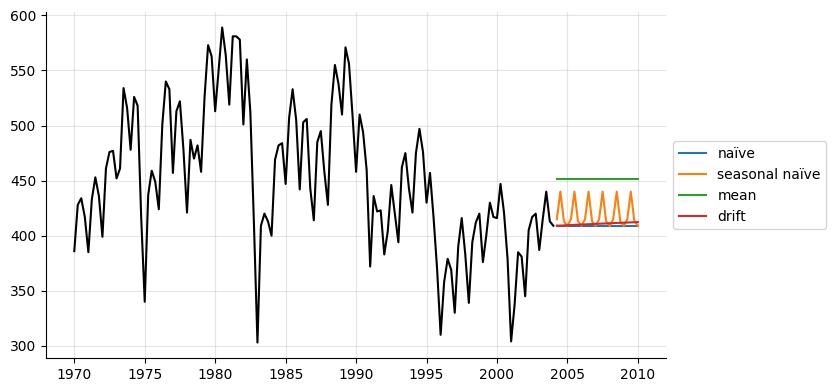

In [13]:
fig, ax = plt.subplots()
ax.plot(bricks.Bricks, color='k')
ax.plot(n.forecast(end='2010'), color='C0', label='naïve')
ax.plot(s.forecast(end='2010'), color='C1', label='seasonal naïve')
ax.plot(m.forecast(end='2010'), color='C2', label='mean')
ax.plot(dr.forecast(end='2010'), color='C3', label='drift')
ax.legend(**legend_right)
ax.grid()

### Example: Australian quarterly beer production

In [14]:
Y = aus_production.Beer
Ytrain = Y[:'2006']
m = TSMean(Ytrain)
n = TSNaive(Ytrain).fit()
s = TSNaiveSeasonal(Ytrain, 4)
dr = TSDrift(Ytrain)

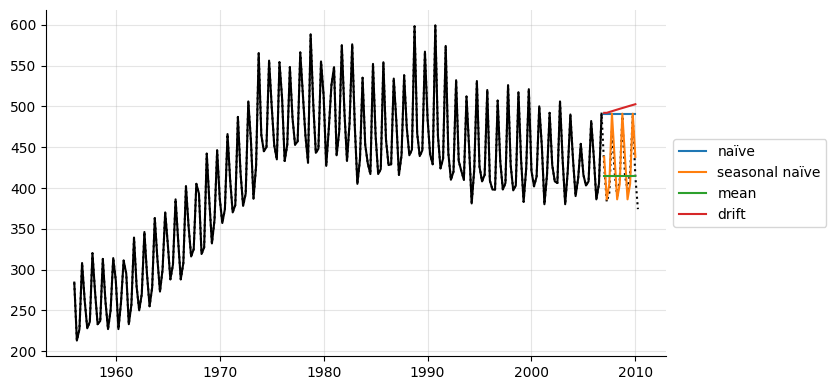

In [15]:
fig, ax = plt.subplots()
ax.plot(Ytrain, 'k')
ax.plot(Y, 'k:')
ax.plot(n.forecast(end='2010'), color='C0', label='naïve')
ax.plot(s.forecast(end='2010'), color='C1', label='seasonal naïve')
ax.plot(m.forecast(end='2010'), color='C2', label='mean')
ax.plot(dr.forecast(end='2010'), color='C3', label='drift')
ax.legend(**legend_right)
ax.grid()

Zoom, and match FPP3 colors

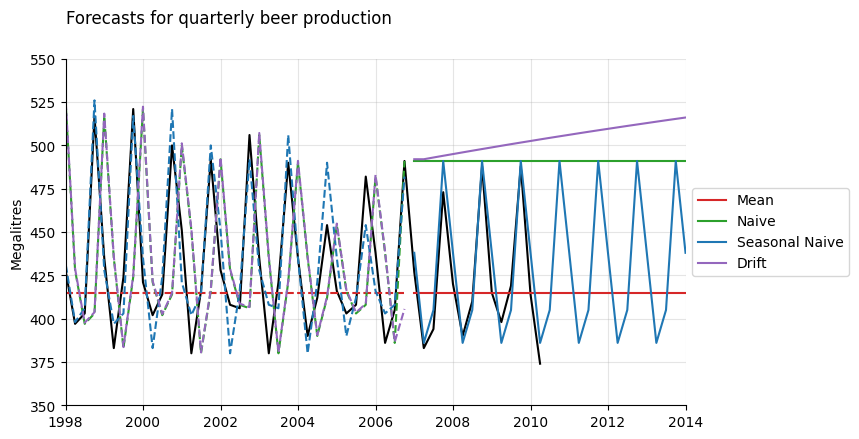

In [16]:
fig, ax = plt.subplots()
ax.plot(Y, color='k')
c = 'C3 C2 C0 C4'.split()
ax.plot(m.predict(),  ls='--', color=c[0])
ax.plot(n.predict(),  ls='--', color=c[1])
ax.plot(s.predict(),  ls='--', color=c[2])
ax.plot(dr.predict(), ls='--', color=c[3])
end = pd.to_datetime('2014')
ax.plot(m.forecast(end=end),  color=c[0], label='Mean')
ax.plot(n.forecast(end=end),  color=c[1], label='Naive')
ax.plot(s.forecast(end=end),  color=c[2], label='Seasonal Naive')
ax.plot(dr.forecast(end=end), color=c[3], label='Drift')
ax.set(ylabel='Megalitres', ylim=(350, 550), xlim=(pd.to_datetime('1998'), end))
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Forecasts for quarterly beer production')
ax.grid()

Sneak peak: RMS relative error.

In [17]:
# see utils.py for RMSE
# (or of course sklearn.metrics)
RMSRE = lambda Y, y: RMSE(1, y/Y)

In [18]:
for model in (m, n, s, dr):
    e = RMSRE(Y['2006':], model.predict('2006', Y.index.max()))
    print(f'{model.__class__.__name__:>20}: {e}')

              TSMean: 0.08223110423264515
             TSNaive: 0.17940561419790907
     TSNaiveSeasonal: 0.03287976922046926
             TSDrift: 0.19616315243316262


Of these, only `TSNaiveSeasonal` is close to capturing the dependence.  (`TSMean` is also kind of close, but is very obviously neglecting a lot of information.)

### Example: Google’s daily closing stock price

See also: [pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/).

In [19]:
GOOG = (
    pd.read_csv('data/gafa_stock.csv')
    .query("Symbol == 'GOOG'")
    .sort_values('Date')
    .reset_index(drop=True)
    .pipe(compute, lambda x: dict(Date = pd.to_datetime(x.Date, format='%Y-%m-%d')))
)

In [20]:
GOOG_2015 = GOOG.query('Date.dt.year == 2015')

In [21]:
len(GOOG_2015)

252

In [22]:
Y = GOOG.Close
Ytrain = GOOG_2015.Close
nsamples = len(GOOG_2015)
m = TSMean(Ytrain)
n = TSNaive(Ytrain).fit()
s = TSNaiveSeasonal(Ytrain, nsamples - 2)
dr = TSDrift(Ytrain)

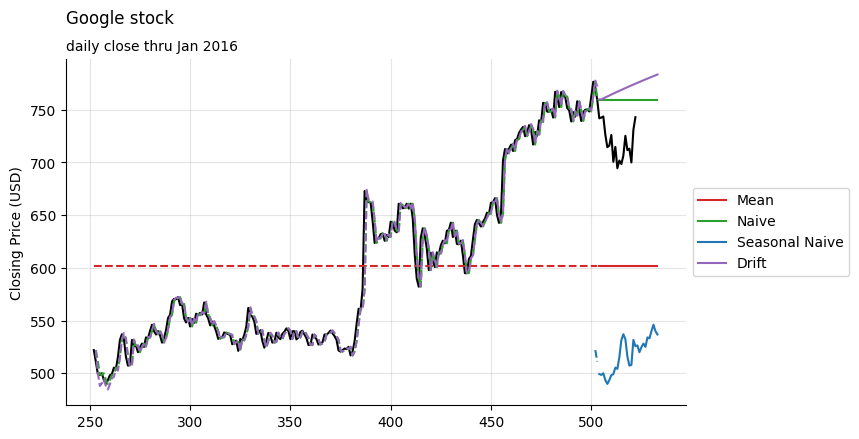

In [23]:
fig, ax = plt.subplots()
ax.plot(Y[GOOG.Date.between('2015-01-01', '2016-01-30')], color='k')
c = 'C3 C2 C0 C4'.split()
ax.plot(m.predict(),  ls='--', color=c[0])
ax.plot(n.predict(),  ls='--', color=c[1])
ax.plot(s.predict(),  ls='--', color=c[2])
ax.plot(dr.predict(), ls='--', color=c[3])
ax.plot(m.forecast(30),  color=c[0], label='Mean')
ax.plot(n.forecast(30),  color=c[1], label='Naive')
ax.plot(s.forecast(30),  color=c[2], label='Seasonal Naive')
ax.plot(dr.forecast(30), color=c[3], label='Drift')
ax.set(ylabel='Closing Price (USD)')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Google stock')
ax.set(title='daily close thru Jan 2016')
ax.grid()

Hard to do better than assuming a random walk for stocks, and that's basically what `TSNaive` is doing.

## 5.3 Fitted values and residuals

[FPP3 Section 5.3](https://otexts.com/fpp3/residuals.html)

### Fitted values

### Residuals

**TODO:** it would be *so* cool if there is (or someday will be) something analogous to R's `augment()` here.

In [24]:
results = GOOG_2015.assign(
    mean=m.predict(),
    naive=n.predict(),
    naive_seasonal=s.predict(),
    drift=dr.predict(),
    resid_mean=m.predict() - Ytrain,
    resid_naive=n.predict() - Ytrain,
    resid_naive_seasonal=s.predict() - Ytrain,
    resid_drift=dr.predict() - Ytrain,
)
results.head()

,Symbol,Open,High,Low,Close,Adj_Close,Volume,Date,mean,naive,naive_seasonal,drift,resid_mean,resid_naive,resid_naive_seasonal,resid_drift
252,GOOG,526.114746,528.362366,521.231628,521.937744,521.937744,1447600,2015-01-02,601.550547,NaN,NaN,NaN,79.612803,NaN,NaN,NaN
253,GOOG,520.396240,521.460388,510.252045,511.057617,511.057617,2059800,2015-01-05,601.550547,521.937744,NaN,521.937744,90.492930,10.880127,NaN,10.880127
254,GOOG,512.181458,513.350037,498.307800,499.212799,499.212799,2899900,2015-01-06,601.550547,511.057617,NaN,500.177490,102.337748,11.844818,NaN,0.964691
255,GOOG,504.225220,504.467896,496.915436,498.357513,498.357513,2065100,2015-01-07,601.550547,499.212799,NaN,487.850326,103.193034,0.855286,NaN,-10.507186
256,GOOG,495.264526,500.724487,488.312805,499.928864,499.928864,3353600,2015-01-08,601.550547,498.357513,NaN,490.497436,101.621683,-1.571351,NaN,-9.431428


## 5.4 Residual diagnostics

[FPP3 Section 5.4](https://otexts.com/fpp3/diagnostics.html)

### Example: Forecasting the Google daily closing stock price

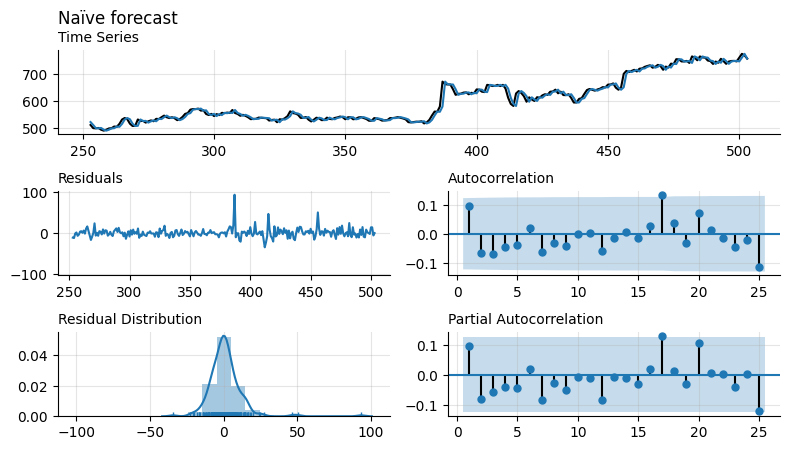

In [25]:
# see utils.py for plot_tsresiduals()
plot_tsresiduals(Ytrain, results.naive)
suptitle('Naïve forecast')
plt.subplots_adjust(top=.9)

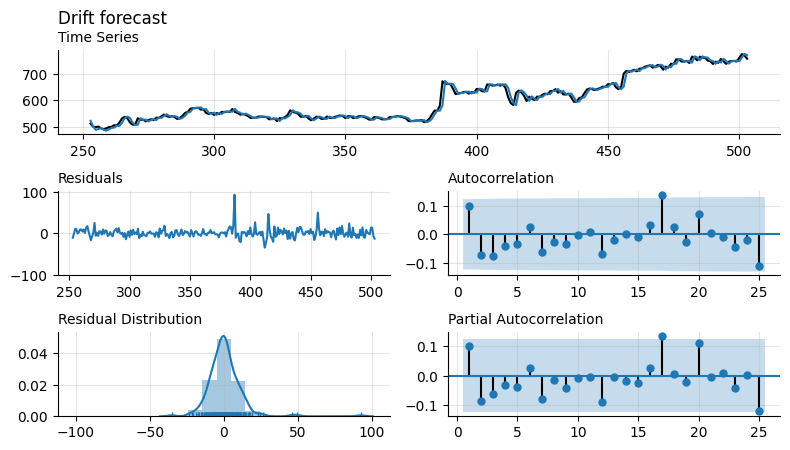

In [26]:
plot_tsresiduals(Ytrain, results.drift)
suptitle('Drift forecast')
plt.subplots_adjust(top=.9)

### Portmanteau tests for autocorrelation

Naïve:

In [27]:
sm.stats.acorr_ljungbox(
    results.resid_naive.dropna(), lags=[10], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,7.582251,0.669568,7.415649,0.685708


Drift:

In [28]:
sm.stats.acorr_ljungbox(
    results.resid_drift.dropna(), model_df=1, lags=[10], boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,7.595931,0.575322,7.438205,0.591595


## 5.5 Distributional forecasts and prediction intervals

[FPP3 Section 5.5](https://otexts.com/fpp3/prediction-intervals.html)

### Forecast distributions

Always seems like the point estimate is enough, until it's not, right?

### Prediction intervals

Calculating this lookup for parity with FPP3, but this makes more sense as a function.

In [29]:
mult = pd.DataFrame(dict(Percentage=np.r_[50:90:5, 90:100]))
mult['Multiplier'] = stats.norm.isf((1 - mult.Percentage/100) / 2)
mult = mult.set_index('Percentage')
mult

,Multiplier
Percentage,
50,0.674490
55,0.755415
60,0.841621
65,0.934589
70,1.036433
75,1.150349
80,1.281552
85,1.439531
90,1.644854


### One-step prediction intervals

Just assuming the same `std` everywhere.

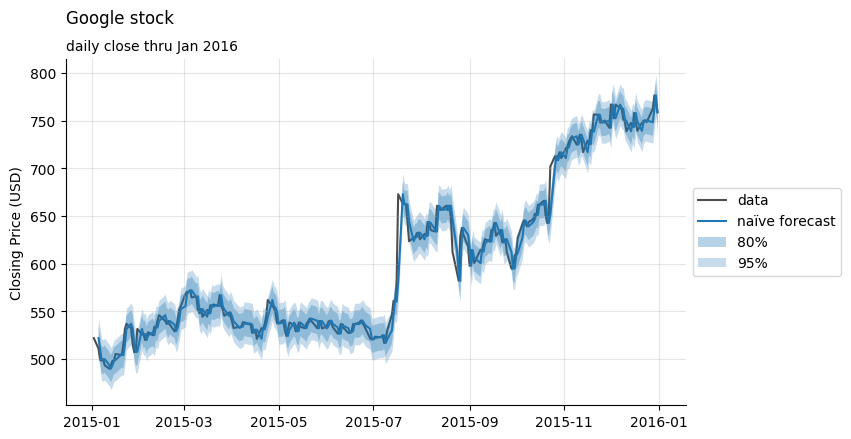

In [30]:
fig, ax = plt.subplots()
r = results.set_index('Date')
ax.plot(r.Close, color='.3', zorder=-10, label='data')
ax.plot(r.naive, lw=1.5, label='naïve forecast')
sigma = results.resid_naive.std()
m80, m95 = mult.Multiplier.loc[[80, 95]]
ax.fill_between(r.index, r.naive - m80*sigma, r.naive + m80*sigma, alpha=.33, lw=0,
                label='80%')
ax.fill_between(r.index, r.naive - m95*sigma, r.naive + m95*sigma, alpha=.25, color='C0', lw=0,
                label='95%')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Google stock')
ax.set(title='daily close thru Jan 2016', ylabel='Closing Price (USD)')
ax.grid()

### Multi-step prediction intervals

For extrapolating into the future, errors grow roughly as $\sqrt{T}$.

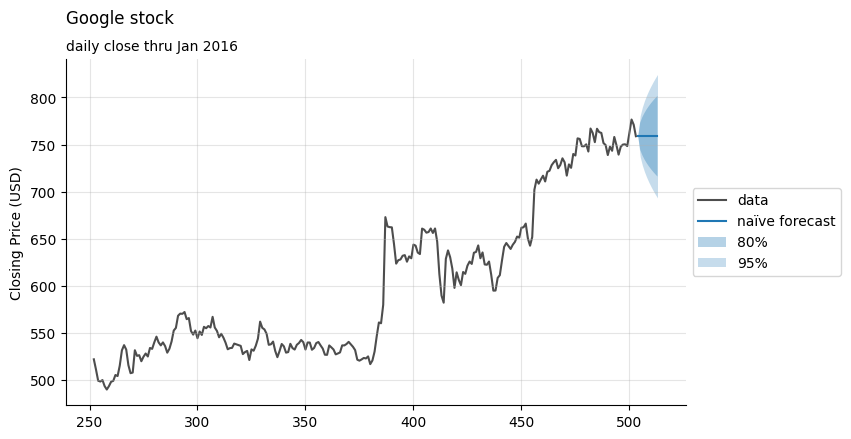

In [31]:
fig, ax = plt.subplots()
g = GOOG[GOOG.Date.lt('2016-02-01')]
ax.plot(GOOG_2015.Close, color='.3', zorder=-10, label='data')
fc = n.forecast(10)
ax.plot(fc, lw=1.5, label='naïve forecast')
sigma = results.resid_naive.std()
m80, m95 = mult.Multiplier.loc[[80, 95]]
didx = fc.index - fc.index.min()
ax.fill_between(fc.index, fc - m80*sigma * np.sqrt(didx), fc + m80*sigma * np.sqrt(didx),
                alpha=.33, lw=0, label='80%')
ax.fill_between(fc.index, fc - m95*sigma * np.sqrt(didx), fc + m95*sigma * np.sqrt(didx),
                alpha=.25, color='C0', lw=0, label='95%')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Google stock')
ax.set(title='daily close thru Jan 2016', ylabel='Closing Price (USD)')
ax.grid()

### Prediction intervals from bootstrapped residuals

Simulate a bunch of futures...

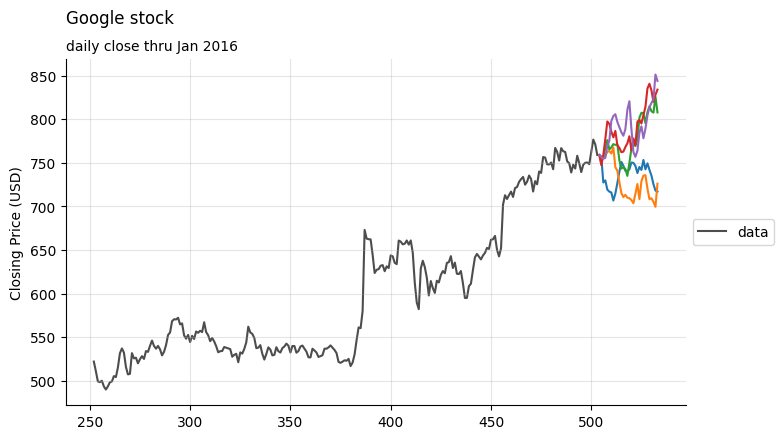

In [32]:
fig, ax = plt.subplots()
g = GOOG[GOOG.Date.lt('2016-02-01')]
ax.plot(GOOG_2015.Close, color='.3', zorder=-10, label='data')
fc = n.forecast(30)
#ax.plot(fc, lw=1.5, label='naïve forecast')
sigma = results.resid_naive.std()
for i in range(5):
    ax.plot(fc + np.r_[0,np.random.normal(0, sigma, len(fc)-1).cumsum()])
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Google stock')
ax.set(title='daily close thru Jan 2016', ylabel='Closing Price (USD)')
ax.grid()

And then pluck confidence intervals from them:

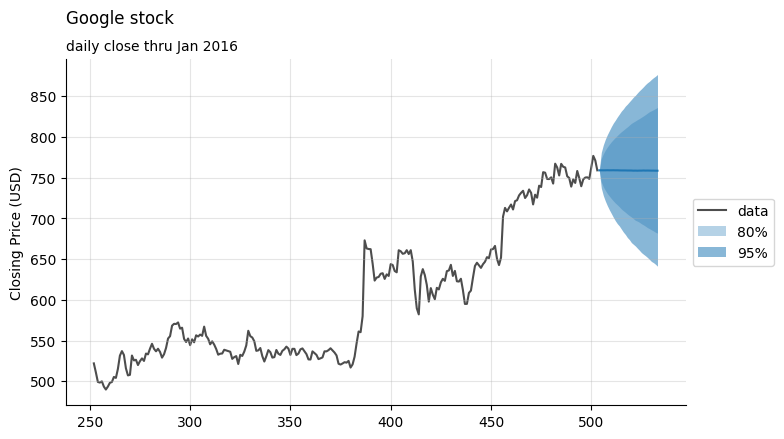

In [33]:
fig, ax = plt.subplots()
g = GOOG[GOOG.Date.lt('2016-02-01')]
ax.plot(GOOG_2015.Close, color='.3', zorder=-10, label='data')
fc = n.forecast(30)
#ax.plot(fc, lw=1.5, label='naïve forecast')
sigma = results.resid_naive.std()
errs = np.array([
    np.r_[0, np.random.normal(0, sigma, len(fc)-1).cumsum()]
    for i in range(50000) ])
lo, mid, hi = np.percentile(errs, [10, 50, 90], axis=0)
ax.plot(fc + mid)
ax.fill_between(fc.index, fc+lo, fc+hi, alpha=.33, color='C0', lw=0, label='80%')
lo, mid, hi = np.percentile(errs, [2.5, 50, 97.5], axis=0)
ax.fill_between(fc.index, fc+lo, fc+hi, alpha=.53, color='C0', lw=0, label='95%')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Google stock')
ax.set(title='daily close thru Jan 2016', ylabel='Closing Price (USD)')
ax.grid()

## 5.6 Forecasting using transformations

[FPP3 Section 5.6](https://otexts.com/fpp3/forecasting-using-transformations.html)

### Prediction intervals with transformations

In R with `fable`, prediction intervals are propagated through any transformations applied.  We won't always be so lucky in Python... just something to keep in mind.

### Forecasting with constraints

`log`/`exp` (or `log1p/expm1`) good for known positive values.  Can also use `logit`/`expit` to keep forecasts within a certain range.

In [34]:
from scipy import special

In [35]:
special.expit(10)

0.9999546021312976

In [36]:
special.logit(special.expit(10))

10.00000000000097

### Bias adjustments

**TODO.**

## 5.7 Forecasting with decomposition

[FPP3 Section 5.7](https://otexts.com/fpp3/forecasting-decomposition.html)

### Example: Employment in the US retail sector

In [37]:
d = pd.read_csv('data/us_employment.csv')
d = us_retail_employment = (
    d
    .assign(date=pd.to_datetime(d.Month, format='%Y %b'))
    .pipe(compute, lambda x: dict(year=x.date.dt.year))
    .query("year >= 1990 and Title == 'Retail Trade'")
    .set_index('date')
    .drop(columns='year Series_ID'.split())
) 
us_retail_employment

,Month,Title,Employed
date,,,
1990-01-01,1990 Jan,Retail Trade,13255.8
1990-02-01,1990 Feb,Retail Trade,12966.3
1990-03-01,1990 Mar,Retail Trade,12938.2
1990-04-01,1990 Apr,Retail Trade,13012.3
1990-05-01,1990 May,Retail Trade,13108.3
...,...,...,...
2019-05-01,2019 May,Retail Trade,15691.6
2019-06-01,2019 Jun,Retail Trade,15775.5
2019-07-01,2019 Jul,Retail Trade,15785.9


Fit an STL and then model seasonal and seasonal-subtracted separately:

In [38]:
stl = sm.tsa.STL(d.Employed).fit()

In [39]:
s_stl = TSNaiveSeasonal(stl.seasonal, 12)

In [40]:
dr_stl = TSDrift(d.Employed - stl.seasonal)

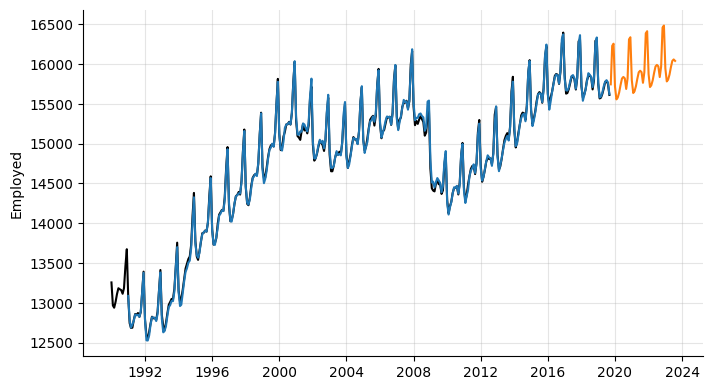

In [41]:
fig, ax = plt.subplots(figsize=sizets)
ax.plot(d.Employed, 'k')
ax.plot(s_stl.predict() + dr_stl.predict())
ax.plot(s_stl.forecast('4y') + dr_stl.forecast('4y'))
ax.set(ylabel='Employed')
ax.grid()

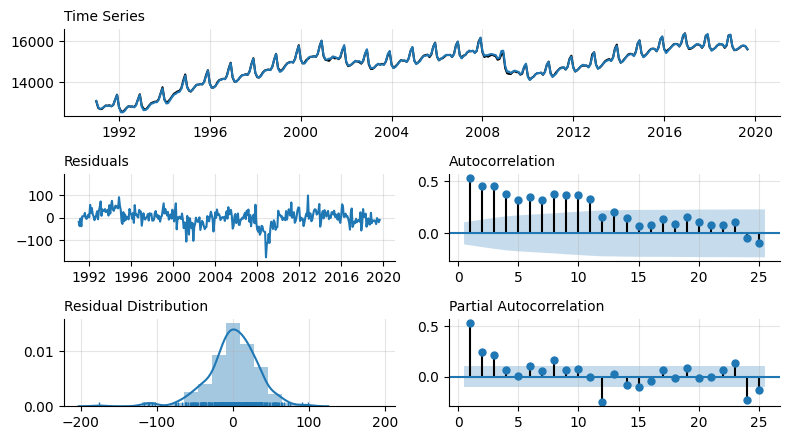

In [42]:
plot_tsresiduals(d.Employed, s_stl.predict() + dr_stl.predict());

Alternatively, only consider the seasonally-adjusted data:

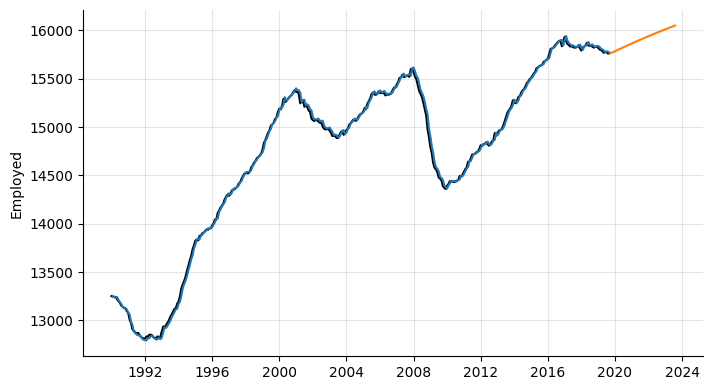

In [43]:
fig, ax = plt.subplots(figsize=sizets)
ax.plot(d.Employed - stl.seasonal, 'k')
ax.plot(dr_stl.predict())
ax.plot(dr_stl.forecast('4y'))
ax.set(ylabel='Employed')
ax.grid()

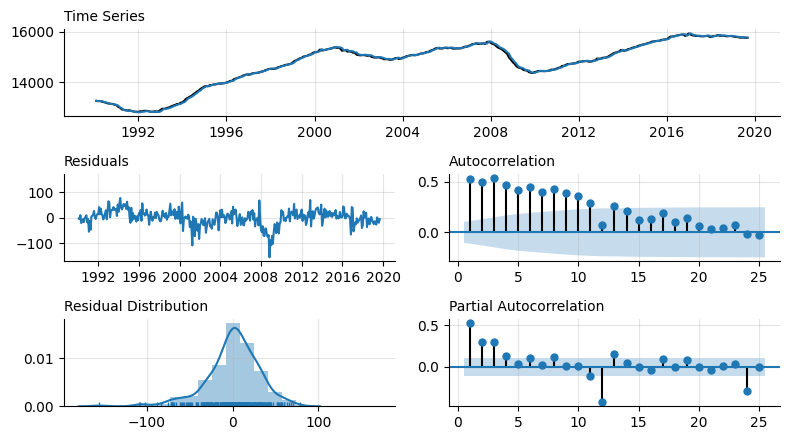

In [44]:
plot_tsresiduals(d.Employed - stl.seasonal, dr_stl.predict());

## 5.8 Evaluating forecast accuracy

[FPP3 Section 5.8](https://otexts.com/fpp3/accuracy.html)

### Training and test sets

### Functions to subset a time series

In [45]:
aus_production['1995':];

In [46]:
aus_production[aus_production.index.quarter == 1];

In [47]:
aus_production.iloc[-20:];

In [48]:
(
    pd.read_csv('data/gafa_stock.csv')
    .groupby('Symbol')
    .max()
)

,Date,Open,High,Low,Close,Adj_Close,Volume
Symbol,,,,,,,
AAPL,2018-12-31,230.779999,233.470001,229.779999,232.070007,230.275482,266380800
AMZN,2018-12-31,2038.109985,2050.500000,2013.000000,2039.510010,2039.510010,23856100
FB,2018-12-31,215.720001,218.619995,214.270004,217.500000,217.500000,169803700
GOOG,2018-12-31,1271.000000,1273.890015,1249.020020,1268.329956,1268.329956,11204900


In [49]:
(
    pd.read_csv('data/gafa_stock.csv')
    .groupby('Symbol')
    .pipe(summarize, lambda x: {
        n: x.Close.sort_values().iloc[-n]
        for n in range(1,5)
    })
)

,1,2,3,4
Symbol,,,,
AAPL,232.070007,229.279999,228.360001,227.990005
AMZN,2039.510010,2012.979980,2012.709961,2004.359985
FB,217.500000,214.669998,210.910004,209.990005
GOOG,1268.329956,1263.699951,1249.300049,1249.099976


### Forecast errors

### Scale-dependent errors

### Percentage errors

### Scaled errors

### Examples

In [50]:
recent_production = aus_production['1992':]
split = '2007-12-01'
beer_train = recent_production[:split]
beer_test = recent_production[split:]

Ytrain = beer_train.Beer
ms = dict(
    Drift = TSDrift(Ytrain),
    Mean = TSMean(Ytrain),
    Naive = TSNaive(Ytrain),
    SeasonalNaive = TSNaiveSeasonal(Ytrain, 4),
)

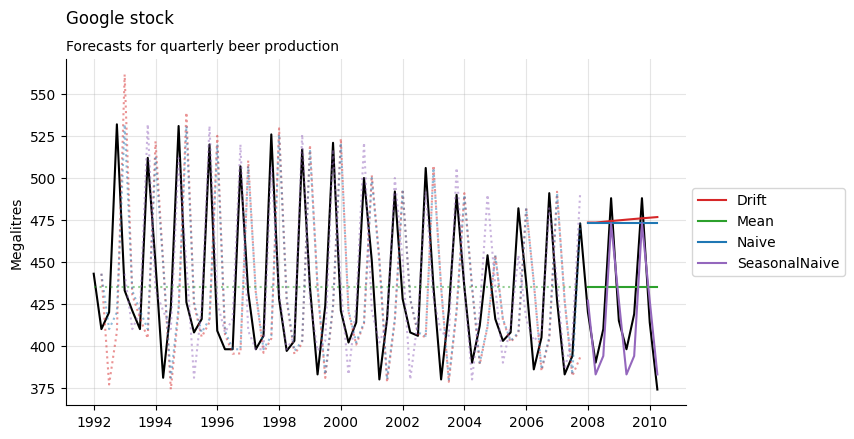

In [51]:
fig, ax = plt.subplots()
Y = recent_production.Beer
ax.plot(Y, color='k')
c = 'C3 C2 C0 C4'.split()
for ((label, model), c) in zip(ms.items(), c):
    ax.plot(model.predict(),  ls=':', color=c, alpha=.5)
    ax.plot(model.forecast(end=Y.index.max()),  color=c, label=label)
ax.set(ylabel='Megalitres')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Google stock')
ax.set(title='Forecasts for quarterly beer production')
ax.grid()

In [52]:
# see utils.py for tsaccuracy()
tsaccuracy(beer_test.Beer, ms)

,RMSE,MAE,MAPE,MASE
Drift,64.367670,58.524029,14.483635,NaN
Mean,38.447245,34.825000,8.283390,NaN
Naive,62.692902,57.400000,14.184424,NaN
SeasonalNaive,14.310835,13.400000,3.168503,NaN


Google?

In [53]:
t1, t2, t3 = pd.to_datetime('2015-01-01 2016-01-01 2016-02-01'.split())
goog_train, goog_test = GOOG[GOOG.Date.between(t1, t2)], GOOG[GOOG.Date.between(t2+pd.to_timedelta('1d'), t3)]

Ytrain = goog_train.Close
ms = dict(
    Drift = TSDrift(Ytrain),
    Mean = TSMean(Ytrain),
    Naive = TSNaive(Ytrain),
)

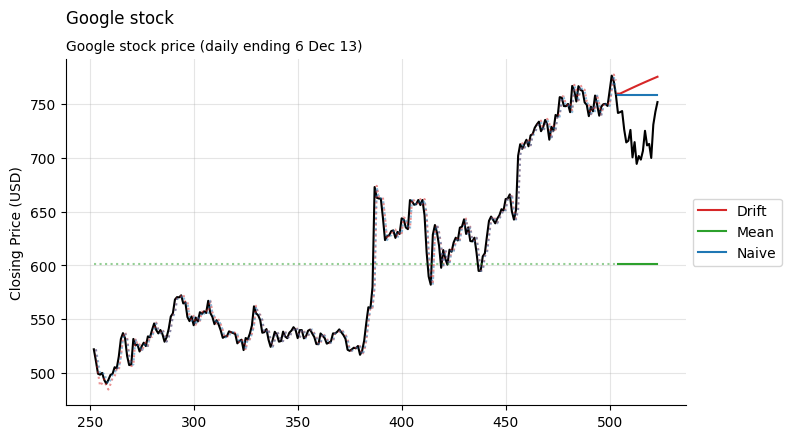

In [54]:
fig, ax = plt.subplots()
#ax.plot(goog_train.Close, color='k')
#ax.plot(goog_test.Close, color='k')
ax.plot(pd.concat((goog_train.Close, goog_test.Close)), 'k')
c = 'C3 C2 C0 C4'.split()
for ((label, model), c) in zip(ms.items(), c):
    ax.plot(model.predict(),  ls=':', color=c, alpha=.5)
    ax.plot(model.forecast(end=goog_test.index.max()),  color=c, label=label)
ax.set(ylabel='Closing Price (USD)')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Google stock')
ax.set(title='Google stock price (daily ending 6 Dec 13)')
ax.grid()

In [55]:
tsaccuracy(goog_test.Close, ms)

,RMSE,MAE,MAPE,MASE
Drift,50.747689,47.285130,6.628159,NaN
Mean,119.861478,118.620455,16.423740,NaN
Naive,42.359750,38.709003,5.434785,NaN


## 5.9 Time series cross-validation

[FPP3 Section 5.9](https://otexts.com/fpp3/tscv.html)

This is a lot more manual than R's `stretch_tsibble()`.  Not sure if there's a readily available Python equivalent, but I think in any case this sort of list comprehension approach is fairly standard for Python sequence analysis.

In [56]:
goog_train_cv = pd.concat([GOOG_2015[:n].assign(id=n) for n in range(3, len(GOOG_2015))])

In [57]:
Y, y = np.transpose([
    (GOOG.Close.loc[d.index.max()+1], TSDrift(d.Close).forecast(1).values[0])
    for (i, d) in goog_train_cv.groupby('id')
])
RMSE(Y, y), MAE(Y, y), MAPE(Y, y)

(11.268190603579248, 7.261240194403708, 1.1940235055379067)

In [58]:
Y = goog_train.Close
y = TSDrift(goog_train.Close).predict()
RMSE(Y, y), MAE(Y, y), MAPE(Y, y)

(11.244363890080821, 7.250572216759058, 1.1937611101216081)

### Example: Forecast horizon accuracy with cross-validation

In [59]:
horizons = np.arange(1, 9)
rmses = np.array([
    np.mean([
        RMSE(GOOG.Close.loc[d.index.max()+horizon], TSDrift(d.Close).forecast(dt=horizon).values[0])
        for (i, d) in goog_train_cv.groupby('id') ])
    for horizon in horizons
])

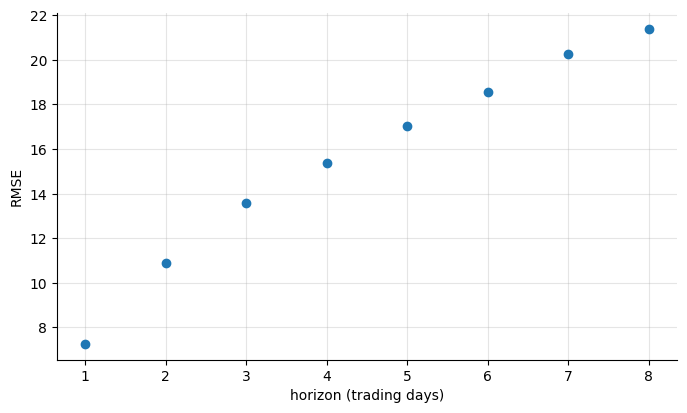

In [60]:
fig, ax = plt.subplots()
ax.plot(horizons, rmses, 'o')
ax.set(xlabel='horizon (trading days)', ylabel='RMSE')
ax.grid()

In [61]:
naive_rmses = np.array([
    np.mean([
        RMSE(GOOG.Close.loc[d.index.max()+horizon], TSNaive(d.Close).forecast(dt=horizon).values[0])
        for (i, d) in goog_train_cv.groupby('id') ])
    for horizon in horizons
])

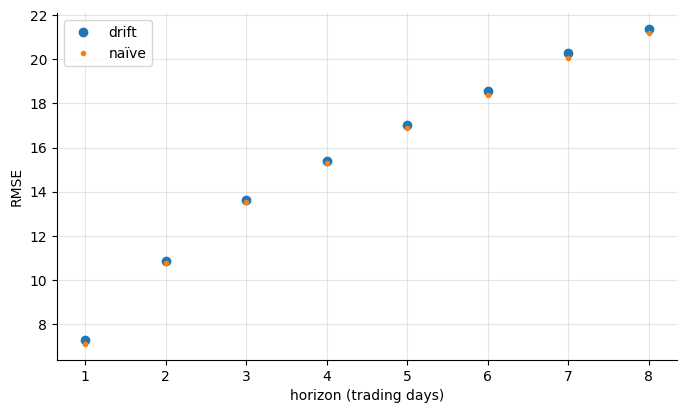

In [62]:
fig, ax = plt.subplots()
ax.plot(horizons, rmses, 'o', label='drift')
ax.plot(horizons, naive_rmses, '.', label='naïve')
ax.set(xlabel='horizon (trading days)', ylabel='RMSE')
ax.legend()
ax.grid()

**TODO:** why is R's "drift" model so much worse than naïve?

<hr/>

[Previous: Time series features](04-Time-series-features.ipynb)
• [Contents](Contents.ipynb)
• [Next: Judgemental forecasts](06-Judgmental-forecasts.ipynb)